# 🪙 American Express - Default Prediction Competition Original Notebook
![](./images/background.jpg)

---

In this [Kaggle competition](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview), you'll use your machine learning expertise to predict credit default. This competition is hosted by American Express. 

> American Express is a globally integrated payments company. The largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success.

The dataset provided is an industrial scale data set of about 5.5 million rows. It has been pre-processed and converted to a lightweight version by raddar for ease of training and better result. This dataset is available in a [parquet format][1].

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format

## Install necessary packages

We can install the necessary package by either running pip install --user <package_name> or include everything in a requirements.txt file and run pip install --user -r requirements.txt. We have put the dependencies in a requirements.txt file so we will use the former method.

NOTE: After installing python packages, restart notebook kernel before proceeding.

In [1]:
!pip install -r requirements.txt --user --quiet

## Imports

In this section we import the packages we need for this example. Make it a habit to gather your imports in a single place. It will make your life easier if you are going to transform this notebook into a Kubeflow pipeline using Kale.

In [2]:
import numpy as np
import pandas as pd
import os, subprocess
import random, zipfile, joblib
import scipy.stats
import warnings
import gc, wget

from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, log_evaluation

warnings.filterwarnings("ignore")

## Project hyper-parameters

In this cell, we define the different hyper-parameters. Defining them in one place makes it easier to experiment with their values and also facilitates the execution of HP Tuning experiments using Kale and Katib.

In [3]:
# Hyper-parameters
N_EST = 30
LR = 0.1

Set random seed for reproducibility

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(2022)

## Download data

In this section, we download the data from kaggle using the Kaggle API credentials

In [5]:
# setup kaggle environment for data download
dataset = "amex-data-integer-dtypes-parquet-format"

# setup kaggle environment for data download
with open('/secret/kaggle-secret/password', 'r') as file:
    kaggle_key = file.read().rstrip()
with open('/secret/kaggle-secret/username', 'r') as file:
    kaggle_user = file.read().rstrip()

os.environ['KAGGLE_USERNAME'], os.environ['KAGGLE_KEY'] = kaggle_user, kaggle_key

# download kaggle's Amex-credit-prediction data
subprocess.run(["kaggle","datasets", "download", "-d", f'raddar/{dataset}'])

CompletedProcess(args=['kaggle', 'datasets', 'download', '-d', 'raddar/amex-data-integer-dtypes-parquet-format'], returncode=0)

In [6]:
# path to download to
data_path = 'data'

# extract Amex-credit-prediction.zip to data_path
with zipfile.ZipFile(f"{dataset}.zip","r") as zip_ref:
    zip_ref.extractall(data_path)
    
# download kaggle's Amex-credit-prediction train_labels.zip
download_link = "https://github.com/kubeflow/examples/blob/master/american-express-default-kaggle-competition/data/train_labels.zip?raw=true"
wget.download(download_link, f'{data_path}/train_labels.zip')

# extract Amex-credit-prediction.zip to data_path
with zipfile.ZipFile(f'{data_path}/train_labels.zip','r') as zip_ref:
    zip_ref.extractall(data_path)
    
# delete zipfiles
subprocess.run(['rm', f'{dataset}.zip'])
subprocess.run(['rm', f'{data_path}/train_labels.zip'])

CompletedProcess(args=['rm', 'data/train_labels.zip'], returncode=0)

## Load the dataset

First, let us load and analyze the data.

The data is in csv format, thus, we use the handy read_csv pandas method.

In [7]:
TRAIN_CSV = (f'{data_path}/train.parquet')
TEST_CSV = f'{data_path}/test.parquet'
TARGET_CSV = f'{data_path}/train_labels.csv'

In [8]:
df_train = pd.read_parquet(TRAIN_CSV)
df_test = pd.read_parquet(TEST_CSV)
target = pd.read_csv(TARGET_CSV).target.values
print(f"target shape: {target.shape}")

target shape: (458913,)


In [9]:
df_train.shape

(5531451, 190)

In [10]:
df_train.isna().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_141           101548
D_142          4587043
D_143                0
D_144            40727
D_145                0
Length: 190, dtype: int64

### Define Helper Functions

In [11]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex_metric_score',
            amex_metric(y_true, y_pred),
            True)

## Feature Engineering

In [12]:
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 
                'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 
                'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 
                'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 
                'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 
                'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 
                'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 
                'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 
                'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 
                'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 
                'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 
                'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 
                'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 
                'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 
                'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 
                'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 
                'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 
                'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 
                'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 
                'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 
                'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 
                'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 
                'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 
                 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 
                 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 
                 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 
                 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 
                 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 
                 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 
                 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 
                 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 
                 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

In [13]:
# feature engineering gotten from https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart
def get_features(df, 
                 features_avg, 
                 features_min, 
                 features_max, 
                 features_last
                ):
    '''
    This function takes a dataframe with all features and returns the aggregated feature grouped by the customer id.
    
    df - dataframe
    '''
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True) # get customer id
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
   
    df_avg = (df
              .groupby(cid)
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             ) 
    
    df_min = (df
              .groupby(cid)
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )
    gc.collect()
    print('Computed min')
    
    df_max = (df
              .groupby(cid)
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )
    gc.collect()
    print('Computed max')
    
    df = (df.loc[last, features_last]
          .rename(columns={f: f"{f}_last" for f in features_last})
          .set_index(np.asarray(cid[last]))
         )
    gc.collect()
    print('Computed last')
    
    df_ = pd.concat([df, df_min, df_max, df_avg], axis=1, )
    
    del df, df_avg, df_min, df_max, cid, last
    
    return df_

In [14]:
# apply feature engineering function
train = get_features(df_train, features_avg, features_min, features_max, features_last)
test = get_features(df_test, features_avg, features_min, features_max, features_last)

Computed min
Computed max
Computed last
Computed min
Computed max
Computed last


In [15]:
# check null values
train.isna().any()

B_1_last    False
B_2_last     True
B_3_last     True
B_4_last    False
B_5_last    False
            ...  
S_18_avg    False
S_22_avg     True
S_23_avg     True
S_25_avg     True
S_26_avg    False
Length: 469, dtype: bool

## Modelling: StratifiedKFold

We cross-validate with a six-fold StratifiedKFold to handle the imbalanced nature of the target.

Lightgbm handles null values efficiently.

In [16]:
# Cross-validation

features = [f for f in train.columns if f != 'customer_ID' and f != 'target']

print(f"{len(features)} features")

score_list = [] # lgbm score per fold
y_pred_list = [] # fold predictions list

# init StratifiedKFold
kf = StratifiedKFold(n_splits=4)

for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None

    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    # init model
    model = LGBMClassifier(n_estimators=N_EST,
                          learning_rate=LR, 
                          random_state=2022)
    # fit model
    model.fit(X_tr, y_tr,
              eval_set = [(X_va, y_va)], 
              eval_metric=[lgb_amex_metric],
              early_stopping_rounds=30,
              callbacks=[log_evaluation(20)])
    
    X_tr, y_tr = None, None
    
    # fold validation set predictions
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    
    # model score
    score = amex_metric(y_va, y_va_pred)

    print(f"Score = {score}")
    score_list.append(score)
    
    # test set predictions
    y_pred_list.append(model.predict_proba(test[features], raw_score=True))
    
    print(f"Fold {fold}") 

# save model
joblib.dump(model, 'lgb.jl')
print(f"OOF Score:                       {np.mean(score_list):.5f}")

469 features
[20]	valid_0's binary_logloss: 0.267976	valid_0's amex_metric_score: 0.750976
Score = 0.7604229987279087
Fold 0
[20]	valid_0's binary_logloss: 0.267339	valid_0's amex_metric_score: 0.753257
Score = 0.7624180573803372
Fold 1
OOF Score:                       0.76142


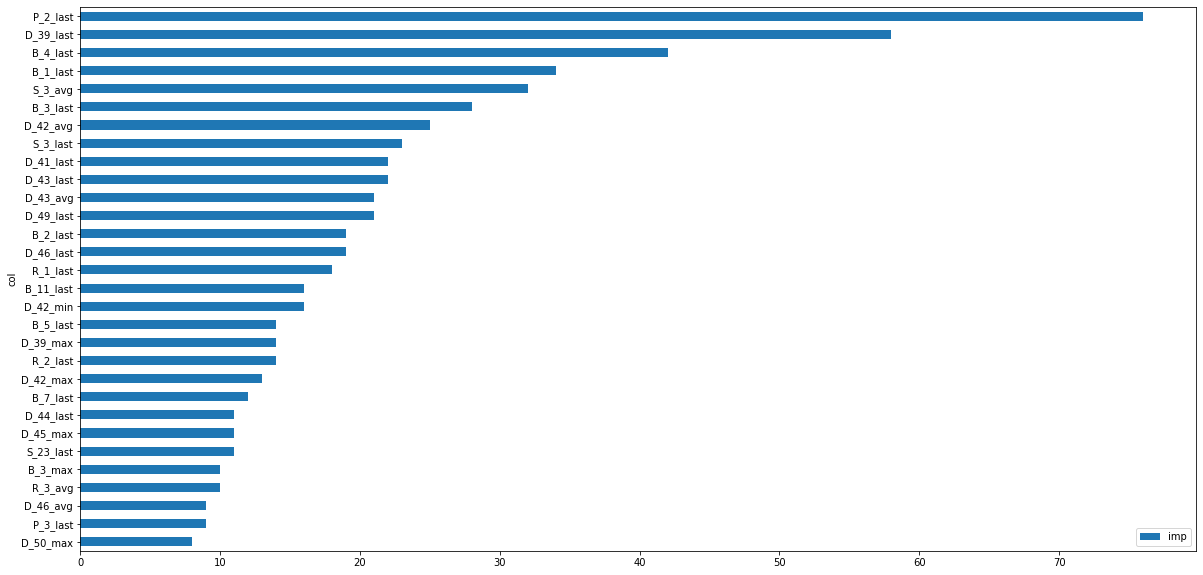

In [19]:
# feature importance for top 30 features
fea_imp = pd.DataFrame({'imp':model.feature_importances_, 'col': features})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

## Evaluation

In [22]:
model = joblib.load('lgb.jl')

In [25]:
binary_logloss = model.booster_.best_score.get('valid_0').get('binary_logloss')

In [26]:
amex_metric_score = model.booster_.best_score.get('valid_0').get('amex_metric_score')

In [27]:
print(binary_logloss)

0.24605493989573005


In [28]:
print(amex_metric_score)

0.7625788091718922


## Submission

In [ ]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': np.mean(y_pred_list, axis=0)})
sub.to_csv('submission.csv', index=False)

In [ ]:
sub